In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym

In [49]:
lstm1 = nn.LSTM(1,64)
lstm2 = nn.LSTM(64,1)

criterion = nn.MSELoss()
optimizer = optim.Adam(chain(lstm1.parameters(),lstm2.parameters()), lr=0.0001)
for i in range(500):
    data = np.sin(np.linspace(0,5,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = Variable(torch.Tensor(xs).view(-1,1,1))
    y = Variable(torch.Tensor(ys))
    lstm1.zero_grad()
    lstm2.zero_grad()
    lstm_out, _ = lstm1(X,None)
    lstm_out, _ = lstm2(lstm_out,None)
    loss = criterion(lstm_out,y)
    loss.backward()
    optimizer.step()
    if i%10 == 0:
        print("i {}, loss {}".format(i,loss.data.numpy()[0]))

i 0, loss 0.5208648443222046
i 10, loss 0.4238623082637787
i 20, loss 0.4141803979873657
i 30, loss 0.318674772977829
i 40, loss 0.33701789379119873
i 50, loss 0.25651898980140686
i 60, loss 0.23078304529190063
i 70, loss 0.15684300661087036
i 80, loss 0.1761147677898407
i 90, loss 0.14083324372768402
i 100, loss 0.165623739361763
i 110, loss 0.10230646282434464
i 120, loss 0.110801100730896
i 130, loss 0.09677600860595703
i 140, loss 0.07723300158977509
i 150, loss 0.09471429884433746
i 160, loss 0.10967113077640533
i 170, loss 0.06346316635608673
i 180, loss 0.06708057224750519
i 190, loss 0.08177399635314941
i 200, loss 0.07358382642269135
i 210, loss 0.06462273001670837
i 220, loss 0.06481217592954636
i 230, loss 0.060764383524656296
i 240, loss 0.06619038432836533
i 250, loss 0.07975935935974121
i 260, loss 0.08655133843421936
i 270, loss 0.050449125468730927
i 280, loss 0.06946719437837601
i 290, loss 0.07651466131210327
i 300, loss 0.08367384970188141
i 310, loss 0.0679016858339

In [50]:
preds = []
hc1 = None
hc2 = None
# warm up
for i in range(len(xs)):
    x = Variable(torch.Tensor(1,1,1).fill_(xs[i]))
    tmp, hc1 = lstm1(x,hc1)
    x, hc2 = lstm2(tmp,hc2)
    preds.append(x.data.numpy()[0][0][0])
# x = Variable(torch.rand(1,1,1))
for i in range(500):
    tmp, hc1 = lstm1(x,hc1)
    x, hc2 = lstm2(tmp,hc2)
    preds.append(x.data.numpy()[0][0][0])

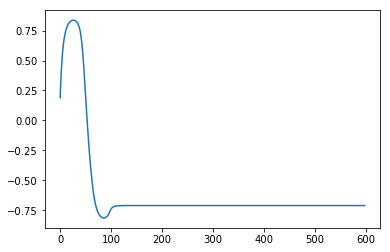

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(preds)
# plt.plot(ys)

In [88]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence,self).__init__()
        self.lstm1 = nn.LSTM(1,64)
        self.lstm2 = nn.LSTM(64,1)
        self.p = 0.5
        
    def forward(self,seq, hc = None):
        out = []
        if hc == None:
            hc1, hc2 = None, None
        else:
            hc1, hc2 = hc
        X_in = torch.unsqueeze(seq[0],0)
        for X in seq.chunk(seq.size(0),dim=0):
            if np.random.rand()>self.p:
                X_in = X
            tmp, hc1 = self.lstm1(X_in,hc1)
            X_in, hc2 = self.lstm2(tmp,hc2)
            out.append(X_in)
        return torch.stack(out).squeeze(1),(hc1,hc2)


seq = Sequence()                
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.001)
for i in range(1000):
    data = np.sin(np.linspace(0,10,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = Variable(torch.Tensor(xs).view(-1,1,1))
    y = Variable(torch.Tensor(ys))
    if i%100==0:
        seq.p = min(seq.p+0.1,0.85)
    optimizer.zero_grad()
    lstm_out,_ = seq(X)
    loss = criterion(lstm_out[20:].view(-1),y[20:])
    loss.backward()
    optimizer.step()
    if i%10 == 0:
        print("i {}, loss {}".format(i,loss.data.numpy()[0]))            

i 0, loss 0.4845571517944336
i 10, loss 0.5398159027099609
i 20, loss 0.4202195107936859
i 30, loss 0.36465927958488464
i 40, loss 0.2206118404865265
i 50, loss 0.15366621315479279
i 60, loss 0.2699629068374634
i 70, loss 0.15163789689540863
i 80, loss 0.09090111404657364
i 90, loss 0.0818706825375557
i 100, loss 0.04155415669083595
i 110, loss 0.06265716999769211
i 120, loss 0.07479992508888245
i 130, loss 0.08010315895080566
i 140, loss 0.1611943244934082
i 150, loss 0.054431572556495667
i 160, loss 0.050887301564216614
i 170, loss 0.23663851618766785
i 180, loss 0.039492860436439514
i 190, loss 0.06412637233734131
i 200, loss 0.051135141402482986
i 210, loss 0.060713496059179306
i 220, loss 0.06083834171295166
i 230, loss 0.03556859493255615
i 240, loss 0.03277938440442085
i 250, loss 0.0492868646979332
i 260, loss 0.043893247842788696
i 270, loss 0.36991414427757263
i 280, loss 0.09016242623329163
i 290, loss 0.03585599735379219
i 300, loss 0.030166685581207275
i 310, loss 0.114143

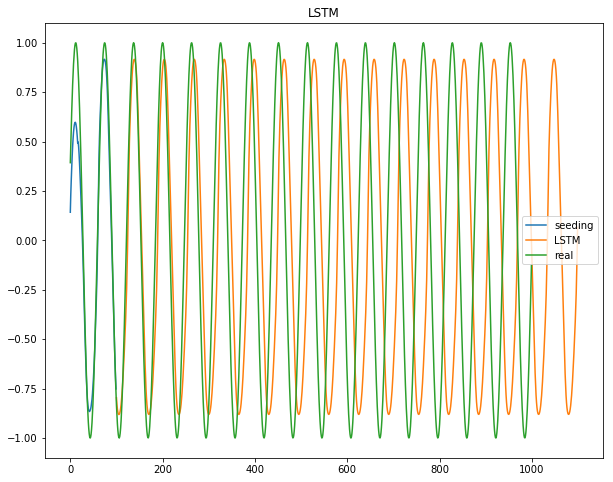

In [90]:
y = np.sin(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
X = Variable(torch.Tensor(y))[:100].view(-1,1,1)
lstm_out,hc = seq(X)
preds = []
pred = lstm_out[-1].view(1,1,1)
for i in range(1000):
    pred,hc = seq(pred,hc)
    preds.append(pred.data.numpy().ravel()[0])

plt.figure(figsize=[10,8])
xs = np.arange(lstm_out.size(0))
plt.plot(xs,lstm_out.data.numpy().ravel())
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','LSTM','real'])
plt.title('LSTM')

In [77]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence,self).__init__()
        self.lstm1 = nn.RNN(1,64,1)
        self.lstm2 = nn.RNN(64,1,1)
        self.p = 0.5
        
    def forward(self,seq, hc = None):
        out = []
        if hc == None:
            hc1, hc2 = None, None
        else:
            hc1, hc2 = hc
        X_in = torch.unsqueeze(seq[0],0)
        for X in seq.chunk(seq.size(0),dim=0):
            if np.random.rand()>self.p:
                X_in = X
            tmp, hc1 = self.lstm1(X_in,hc1)
            X_in, hc2 = self.lstm2(tmp,hc2)
            out.append(X_in)
        return torch.stack(out).squeeze(1),(hc1,hc2)


seq = Sequence()                
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.001)
for i in range(1000):
    data = np.sin(np.linspace(0,10,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = Variable(torch.Tensor(xs).view(-1,1,1))
    y = Variable(torch.Tensor(ys))
    if i%100==0:
        seq.p = min(seq.p+0.1,0.8)
    optimizer.zero_grad()
    lstm_out,_ = seq(X)
    loss = criterion(lstm_out[20:].view(-1),y[20:])
    loss.backward()
    optimizer.step()
    if i%10 == 0:
        print("i {}, loss {}".format(i,loss.data.numpy()[0]))  

i 0, loss 0.6766386032104492
i 10, loss 0.08960302174091339
i 20, loss 0.06483016163110733
i 30, loss 0.02981492318212986
i 40, loss 0.04954509809613228
i 50, loss 0.03407452628016472
i 60, loss 0.025375887751579285
i 70, loss 0.09891653805971146
i 80, loss 0.2540358603000641
i 90, loss 0.07317787408828735
i 100, loss 0.03900996968150139
i 110, loss 0.0674595832824707
i 120, loss 0.10516145825386047
i 130, loss 0.10297923535108566
i 140, loss 0.046210967004299164
i 150, loss 0.054667647927999496
i 160, loss 0.023959867656230927
i 170, loss 0.16390299797058105
i 180, loss 0.05645120143890381
i 190, loss 0.042052023112773895
i 200, loss 0.11774586141109467
i 210, loss 0.08688152581453323
i 220, loss 0.08099570870399475
i 230, loss 0.3180047571659088
i 240, loss 0.10113456845283508
i 250, loss 0.047235146164894104
i 260, loss 0.2902715802192688
i 270, loss 0.3443862199783325
i 280, loss 0.03771297633647919
i 290, loss 0.028061293065547943
i 300, loss 0.06659778952598572
i 310, loss 0.1239

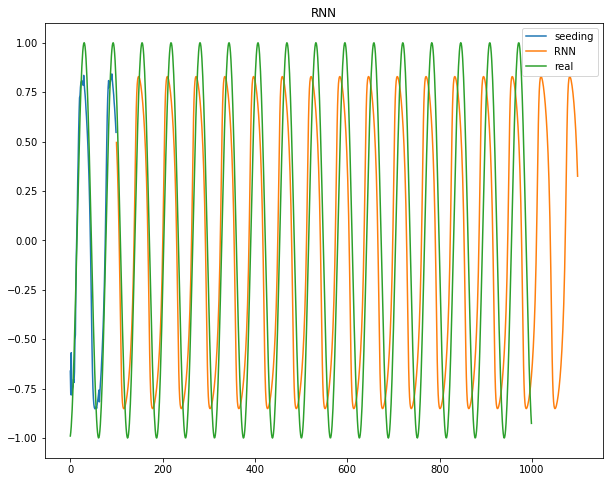

In [83]:
y = np.sin(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
X = Variable(torch.Tensor(y))[:100].view(-1,1,1)
lstm_out,hc = seq(X)
preds = []
pred = lstm_out[-1].view(1,1,1)
for i in range(1000):
    pred,hc = seq(pred,hc)
    preds.append(pred.data.numpy().ravel()[0])

plt.figure(figsize=[10,8])
xs = np.arange(lstm_out.size(0))
plt.plot(xs,lstm_out.data.numpy().ravel())
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','RNN','real'])
plt.title('RNN')

In [91]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence,self).__init__()
        self.lstm1 = nn.GRU(1,64,1)
        self.lstm2 = nn.GRU(64,1,1)
        self.p = 0.5
        
    def forward(self,seq, hc = None):
        out = []
        if hc == None:
            hc1, hc2 = None, None
        else:
            hc1, hc2 = hc
        X_in = torch.unsqueeze(seq[0],0)
        for X in seq.chunk(seq.size(0),dim=0):
            if np.random.rand()>self.p:
                X_in = X
            tmp, hc1 = self.lstm1(X_in,hc1)
            X_in, hc2 = self.lstm2(tmp,hc2)
            out.append(X_in)
        return torch.stack(out).squeeze(1),(hc1,hc2)


seq = Sequence()                
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.001)
for i in range(1000):
    data = np.sin(np.linspace(0,10,100)+2*np.pi*np.random.rand())
    xs = data[:-1]
    ys = data[1:]
    X = Variable(torch.Tensor(xs).view(-1,1,1))
    y = Variable(torch.Tensor(ys))
    if i%100==0:
        seq.p = min(seq.p+0.1,0.8)
    optimizer.zero_grad()
    lstm_out,_ = seq(X)
    loss = criterion(lstm_out[20:].view(-1),y[20:])
    loss.backward()
    optimizer.step()
    if i%10 == 0:
        print("i {}, loss {}".format(i,loss.data.numpy()[0]))  

i 0, loss 0.98842853307724
i 10, loss 0.5231029391288757
i 20, loss 0.3500158190727234
i 30, loss 0.5045902132987976
i 40, loss 0.21809324622154236
i 50, loss 0.09845162183046341
i 60, loss 0.0725177749991417
i 70, loss 0.060021981596946716
i 80, loss 0.02654363587498665
i 90, loss 0.016544466838240623
i 100, loss 0.03895098343491554
i 110, loss 0.03213312849402428
i 120, loss 0.03785308077931404
i 130, loss 0.038659702986478806
i 140, loss 0.02034085802733898
i 150, loss 0.054655447602272034
i 160, loss 0.01437431015074253
i 170, loss 0.011392463929951191
i 180, loss 0.013599799945950508
i 190, loss 0.015123248100280762
i 200, loss 0.01922178454697132
i 210, loss 0.014567064121365547
i 220, loss 0.02329767867922783
i 230, loss 0.014206171035766602
i 240, loss 0.037089500576257706
i 250, loss 0.03275023400783539
i 260, loss 0.013436095789074898
i 270, loss 0.0173764880746603
i 280, loss 0.014336385764181614
i 290, loss 0.012342079542577267
i 300, loss 0.0589757077395916
i 310, loss 0.0

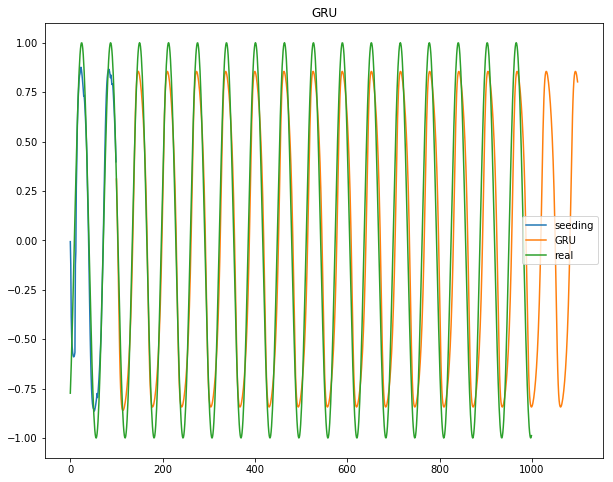

In [93]:
y = np.sin(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
X = Variable(torch.Tensor(y))[:100].view(-1,1,1)
lstm_out,hc = seq(X)
preds = []
pred = lstm_out[-1].view(1,1,1)
for i in range(1000):
    pred,hc = seq(pred,hc)
    preds.append(pred.data.numpy().ravel()[0])

plt.figure(figsize=[10,8])
xs = np.arange(lstm_out.size(0))
plt.plot(xs,lstm_out.data.numpy().ravel())
xs = np.arange(1000)+len(xs)
plt.plot(xs,preds)
plt.plot(y)
plt.legend(['seeding','GRU','real'])
plt.title('GRU')